# Data analysis

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from pathlib import Path
import sys

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. EDA of SNAP & HIU

### 1.1. SNAP EDA

In [15]:
need_cols = ["food_insecurity_need", "housing_need", "loneliness_need"]
merged_snap_df[need_cols].mean().sort_values(ascending=False).plot.bar(title="Prevalence of SDoH Needs", ylabel="Proportion of Users")

KeyError: "None of [Index(['food_insecurity_need', 'housing_need', 'loneliness_need'], dtype='object')] are in the [columns]"

### 1.2. HIU EDA

## 3. Clustering of SNAP needs.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

snap_referrals_df = pd.read_csv('../data/processed/merged_referrals_snap.csv')

In [ ]:
qlc_cols = [
    'Control (QLC)',
    'Personal cleanliness (QLC)',
    'Food and drink (QLC)',
    'Personal safety (QLC)',
    'Social Participation (QLC)',
    'Occupation (QLC)',
    'Accommodation (QLC)',
    'Dignity 1 (QLC)',
    'Dignity 2 (QLC)',
    'Medication (QLC)',
    'Finances (QLC)'
]

# Filter to Timepoint 1 (start of support)
df_qlc = snap_referrals_df[snap_referrals_df['Timepoint'] == 1].copy()

# Drop rows with missing QLC values
df_qlc = df_qlc.dropna(subset=qlc_cols)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_qlc[qlc_cols])

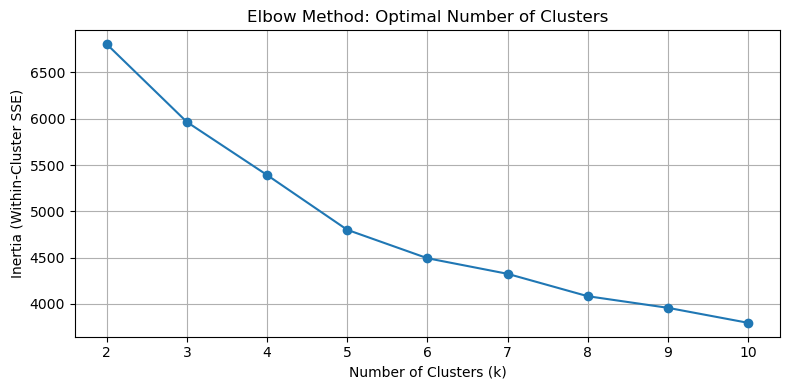

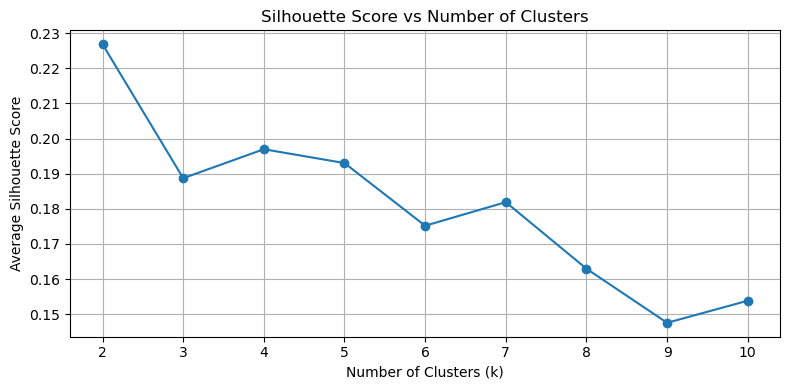

In [19]:
# Try k from 2 to 10
inertia = []
K_range = range(2, 11)

silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's go for four clusters.

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_qlc['cluster'] = kmeans.fit_predict(X_scaled)

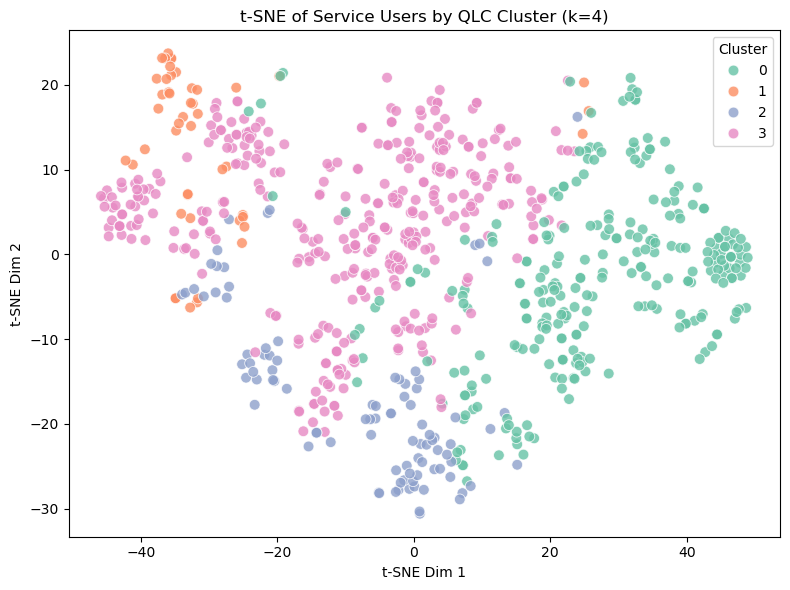

In [21]:
from sklearn.manifold import TSNE

tsne_final = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_final = tsne_final.fit_transform(X_scaled)

df_qlc['tsne_1'] = X_tsne_final[:, 0]
df_qlc['tsne_2'] = X_tsne_final[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_qlc, x='tsne_1', y='tsne_2',
    hue='cluster', palette='Set2', s=60, alpha=0.8
)
plt.title("t-SNE of Service Users by QLC Cluster (k=4)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

PCA Loadings:
                              PC1    PC2    PC3    PC4
Control (QLC)               0.401 -0.083  0.035  0.024
Personal cleanliness (QLC)  0.401 -0.048 -0.215 -0.265
Food and drink (QLC)        0.354 -0.124 -0.199 -0.301
Personal safety (QLC)       0.270 -0.291  0.093 -0.086
Social Participation (QLC)  0.350 -0.075  0.031  0.555
Occupation (QLC)            0.358 -0.088  0.091  0.559
Accommodation (QLC)         0.347 -0.062 -0.262 -0.329
Dignity 1 (QLC)             0.201  0.659  0.030 -0.034
Dignity 2 (QLC)             0.204  0.656  0.061 -0.014
Medication (QLC)            0.101 -0.091  0.630 -0.298
Finances (QLC)              0.127 -0.020  0.652 -0.115


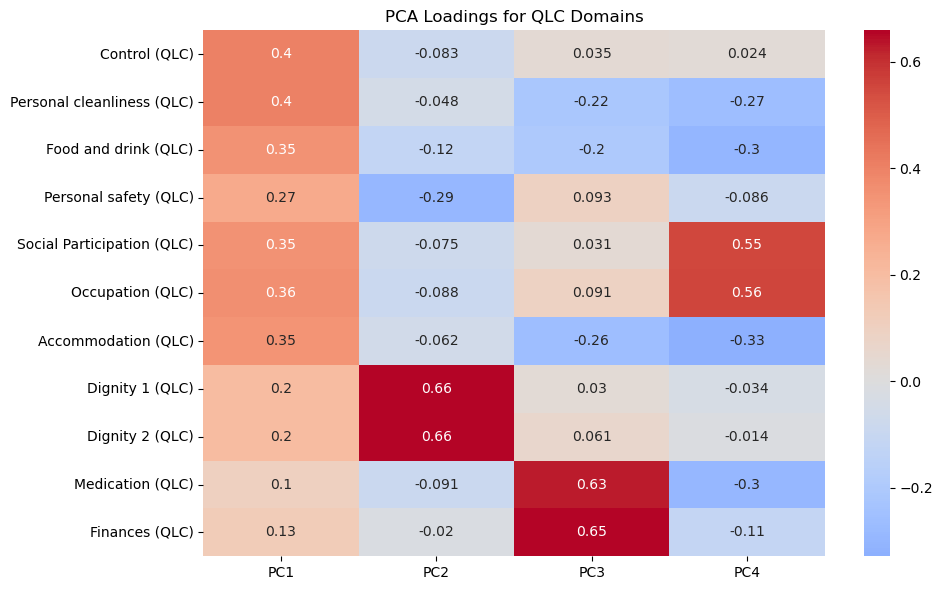

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Loadings (contributions of original features to each PC)
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3', 'PC4'],
    index=qlc_cols
)

print("PCA Loadings:")
print(loadings_df.round(3))

# Optional: plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings for QLC Domains")
plt.tight_layout()
plt.show()

Cluster profiles (mean QLC scores):


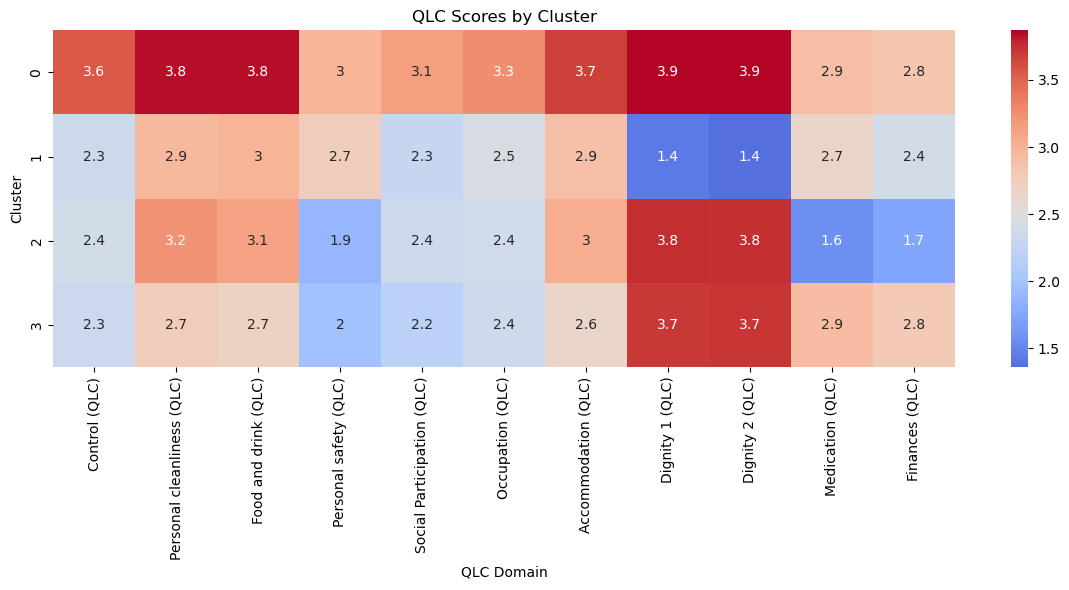

In [26]:
cluster_profiles = df_qlc.groupby('cluster')[qlc_cols].mean().round(2)
print("Cluster profiles (mean QLC scores):")
cluster_profiles

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, annot=True, center=2.5, cmap='coolwarm')
plt.title("QLC Scores by Cluster")
plt.xlabel("QLC Domain")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

## 4. Clustering of HIU needs assessement

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

hiu_referrals_df = pd.read_csv('../data/processed/merged_referrals_hiu.csv')

hiu_cols = hiu_referrals_df.columns.to_list()

In [50]:
# Filter to rows where Q6 is missing (i.e., outcomes not recorded)
hiu_filtered = hiu_referrals_df[hiu_referrals_df['Q6. Why wasn\'t it possible to record outcomes for this client?'].isna()]

# Identify all 'level' columns
level_cols = [col for col in hiu_filtered.columns if 'level' in col.lower()]
# Exclude East Riding IAH Levels
level_cols = [col for col in level_cols if 'east riding' not in col.lower()]

# Exclude 'Not recorded' values
hiu_filtered_clean = hiu_filtered.copy()
for col in level_cols:
    hiu_filtered_clean = hiu_filtered_clean[hiu_filtered_clean[col].str.lower() != 'not recorded']

# Drop rows with any missing level values
hiu_filtered_clean = hiu_filtered_clean.dropna(subset=level_cols)

In [51]:
# Deduplicate to one row per service user (e.g., first row per case_ref)
hiu_per_user = hiu_filtered_clean.sort_values('referral_date').drop_duplicates('case_ref')

# Prepare categorical encoder
encoder = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), level_cols)
])

# Encode the data
encoded_data = encoder.fit_transform(hiu_per_user)

# Optional: store mapping between encoded vectors and case references
case_refs = hiu_per_user['case_ref'].reset_index(drop=True)

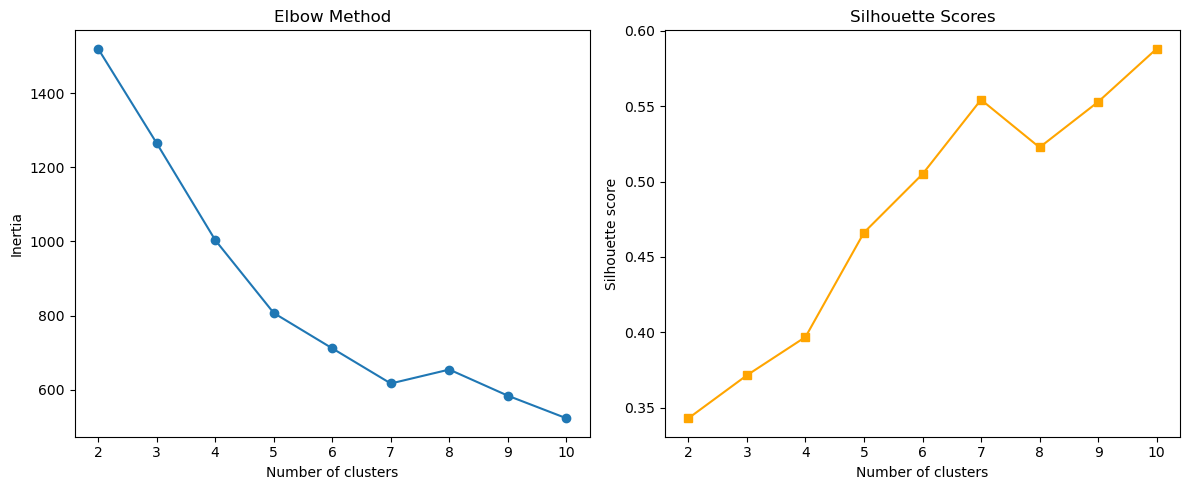

In [53]:
# Elbow method and silhouette analysis
inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(encoded_data, kmeans.labels_))

# Plot elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='s', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.tight_layout()
plt.show()

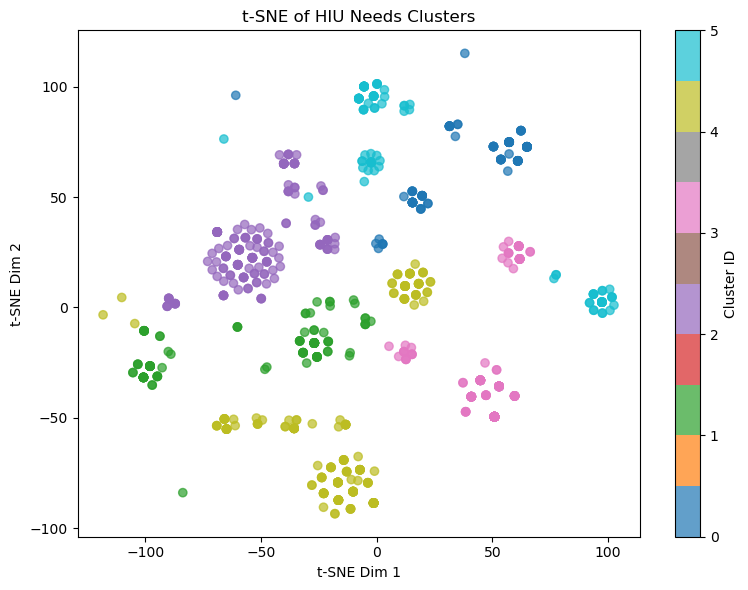

In [57]:
# Final clustering
k_final = 6
kmeans_final = KMeans(n_clusters=k_final, random_state=42)
clusters = kmeans_final.fit_predict(encoded_data)
hiu_per_user['cluster'] = kmeans_final.fit_predict(encoded_data)

# t-SNE visualisation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(encoded_data)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("t-SNE of HIU Needs Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

In [61]:
# List of level columns used
level_cols_filtered = encoder.transformers_[0][2]  # extracted from the ColumnTransformer

# Calculate frequency tables for each level column by cluster
cluster_profiles = {}

for col in level_cols_filtered:
    crosstab = pd.crosstab(hiu_per_user['cluster'], hiu_per_user[col], normalize='index') * 100
    cluster_profiles[col] = crosstab.round(1)

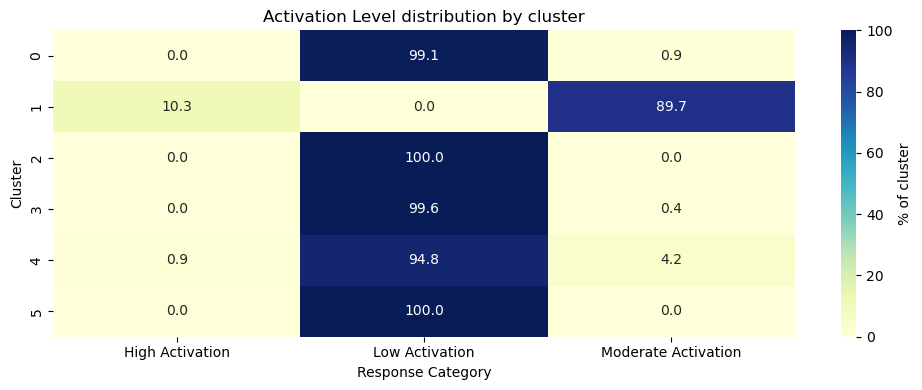

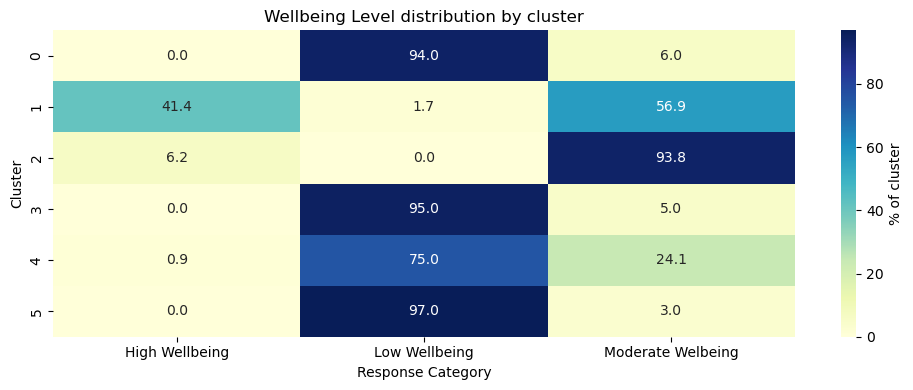

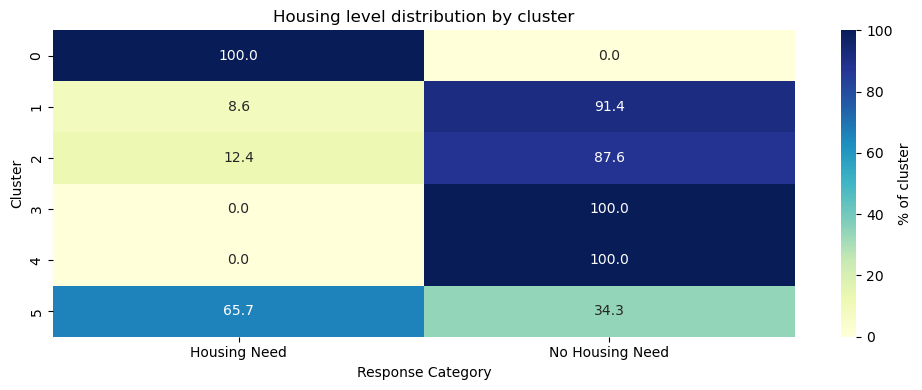

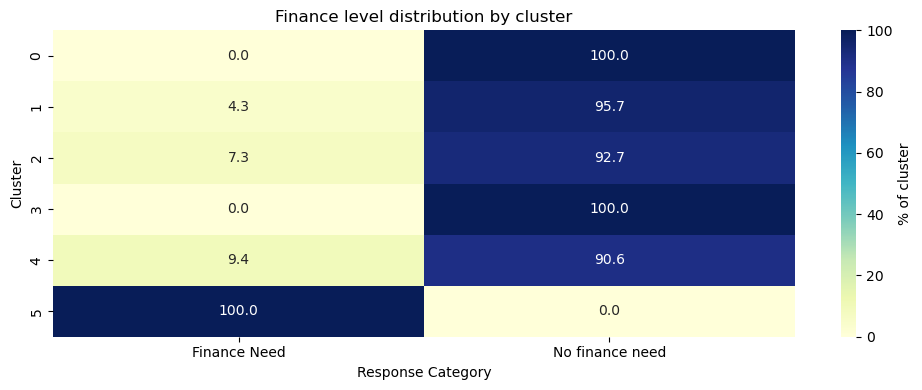

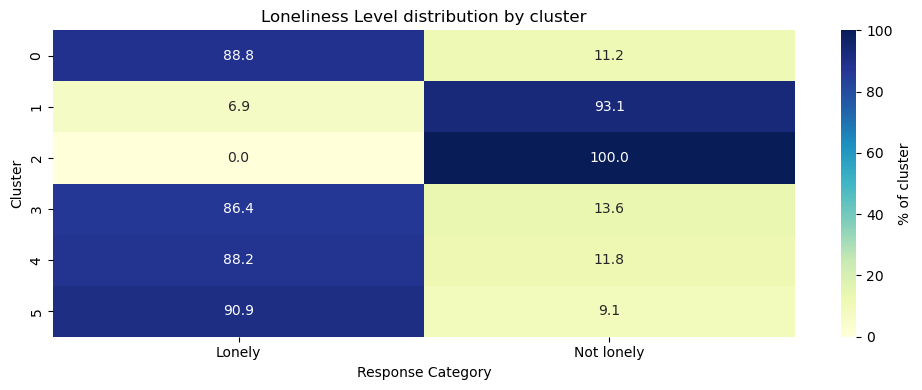

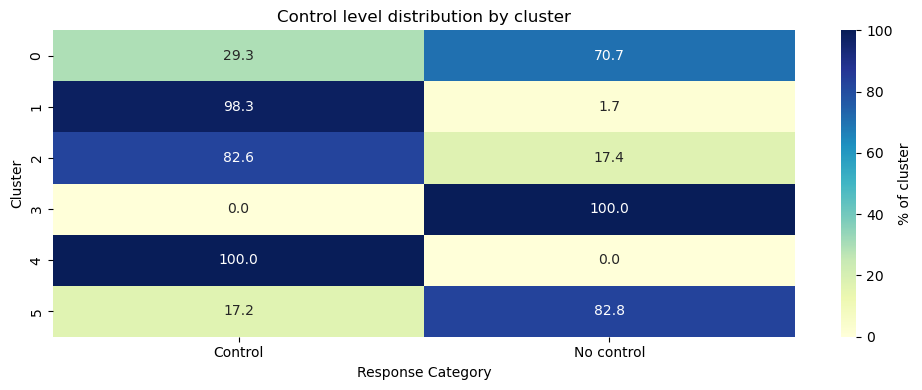

In [62]:
# Plot heatmaps of level distribution per cluster
for col in level_cols_filtered:
    crosstab = pd.crosstab(hiu_per_user['cluster'], hiu_per_user[col], normalize='index') * 100
    plt.figure(figsize=(10, 4))
    sns.heatmap(crosstab, annot=True, cmap='YlGnBu', fmt=".1f", cbar_kws={'label': '% of cluster'})
    plt.title(f"{col} distribution by cluster")
    plt.xlabel("Response Category")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()